[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/advection_diffusion_2d/advection-diffusion-2d.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/examples/blob/main/examples/PyMPDATA_examples/advection_diffusion_2d/advection-diffusion-2d.ipynb)

In [1]:
from open_atmos_jupyter_utils import show_plot

TOC:
- run a basic constant-coefficient advection-diffusion simulation with Trixi.jl
- run analogous simulation with PyMPDATA
- compare output

## common settings

In [2]:
SETUP = {
    "nx": 32,
    "ny": 32,
    "ux": 0.5,
    "uy": 0.25,
    "dt": 0.025,
    "tmax": 1.0
}

import json
with open('setup.json', 'w', encoding='UTF-8') as f:
    json.dump(SETUP, f)

## Trixi.jl

In [ ]:
%%writefile trixi.jl
import Pkg
Pkg.add(["JSON", "Trixi", "OrdinaryDiffEq"])
using JSON
using Trixi
using OrdinaryDiffEq

setup = JSON.parsefile("./setup.json")

advection_velocity = (setup["ux"], setup["uy"])
equations = LinearScalarAdvectionEquation2D(advection_velocity)
solver = DGSEM(polydeg = 3)

function initial_condition(x, t, equations::LinearScalarAdvectionEquation2D)
    return SVector(exp(-100 * (x[1]^2 + x[2]^2)))
end

cells_per_dimension = (setup["nx"], setup["ny"])
coordinates_min = (-1.0, -1.0)
coordinates_max = ( 1.0,  1.0)

mesh = StructuredMesh(cells_per_dimension, coordinates_min, coordinates_max)
semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, solver)

tspan = (0.0, setup["tmax"])
ode = semidiscretize(semi, tspan);

summary_callback = SummaryCallback()
save_solution = SaveSolutionCallback(interval=100)

stepsize_callback = StepsizeCallback(cfl = 1.6)

callbacks = CallbackSet(summary_callback, save_solution, stepsize_callback)

time_int_tol = 1e-6
sol = solve(ode, CarpenterKennedy2N54();
            abstol = time_int_tol,
            reltol = time_int_tol,
            dt = setup["dt"],
            ode_default_options()..., callback = callbacks);

summary_callback()

In [ ]:
!julia trixi.jl

## PyMPDATA

In [3]:
import os
import sympy as sp
import h5py
import numpy as np
import imageio
from IPython.display import display
from ipywidgets import FloatProgress
import matplotlib.pyplot as plt
from PyMPDATA import Solver, ScalarField, VectorField, Stepper, Options
from PyMPDATA.boundary_conditions import Periodic

In [4]:
steps_per_iter = 1
opt = Options(n_iters=3, non_zero_mu_coeff=True, infinite_gauge=True, nonoscillatory=True)

In [5]:
x0 = -1.
y0 = -1.
boundary_conditions = (Periodic(), Periodic())

In [6]:
mu = 0.0
min_x, min_y = -1, -1
max_x, max_y = 1, 1
dx = (max_x - min_x) / SETUP['nx']
dy = (max_y - min_y) / SETUP['ny']
nt = int(SETUP['tmax'] / SETUP['dt'])
Cx = SETUP['ux'] * SETUP['dt'] / dx
Cy = SETUP['uy'] * SETUP['dt'] / dy
# solution_symbolic = sp.sympify("sin(pi*(x+y))*exp(-mu*pi**2*t) + 1", rational=True)
solution_symbolic = sp.sympify("exp(-5*(x**2 + y**2)) + 1", rational=True) #exp(-100 * (x[1]^2 + x[2]^2)))
solution = solution_symbolic.subs({"mu": mu})

In [7]:
def init_conditions(x, y):
    return solution_symbolic.subs({"t":0, "x": x, "y": y}).evalf()

In [8]:
z = np.array(
    [
        # [
            init_conditions(x, y) for x in np.linspace(min_x, max_x, SETUP['nx'])
        # ]
        for y in np.linspace(min_y, max_y, SETUP['ny'])
    ],
    dtype=float
).reshape((SETUP['nx'], SETUP['ny']))

In [9]:
def get_fwhm_edges(field_array):
    half_max = (np.max(field_array) - 1) / 2
    cells_above_half = np.sign(field_array - half_max - 1)
    cells_above_half.astype(int)
    # find the edges of the shape
    edge = np.zeros_like(cells_above_half)
    for i in range(cells_above_half.shape[0]):
        for j in range(cells_above_half.shape[1]):
            if cells_above_half[i, j] == 1:
                neighbor_north = cells_above_half[i-1, j] if i > 0 else cells_above_half[cells_above_half.shape[0]-1, j]
                neighbor_south = cells_above_half[i+1, j] if i < cells_above_half.shape[0]-1 else cells_above_half[0, j]
                neighbor_west = cells_above_half[i, j-1] if j > 0 else cells_above_half[i, cells_above_half.shape[1]-1]
                neighbor_east = cells_above_half[i, j+1] if j < cells_above_half.shape[1]-1 else cells_above_half[i, 0]
                if neighbor_north <= 0 or neighbor_south <= 0 or neighbor_west <= 0 or neighbor_east <= 0:
                    edge[i, j] = 1
    return edge

In [10]:
advectee = ScalarField(data=z, halo=opt.n_halo, boundary_conditions=boundary_conditions)

In [11]:
field_x = np.full((SETUP['nx']+1, SETUP['ny']), Cx, dtype=opt.dtype)
field_y = np.full((SETUP['nx'], SETUP['ny']+1), Cy, dtype=opt.dtype)
advector = VectorField(
    data=(field_x, field_y),
    halo=opt.n_halo,
    boundary_conditions=(boundary_conditions[0], Periodic())
)

In [12]:
stepper = Stepper(options=opt, n_dims=2)

In [13]:
# create a solver
solver = Solver(stepper=stepper, advector=advector, advectee=advectee)

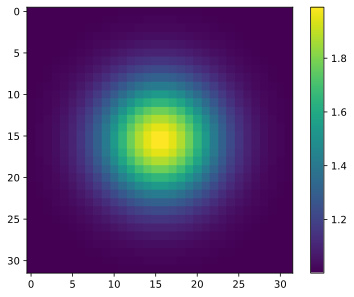

HTML(value="<a href='./tmppjek7352.pdf' target='_blank'>./tmppjek7352.pdf</a><br>")

In [14]:
# plot initial conditions
plt.imshow(solver.advectee.get().copy(), cmap='viridis')
plt.colorbar()
show_plot()

In [15]:
progbar = FloatProgress(value=0, min=0, max=1)
display(progbar)

states_history = [solver.advectee.get().copy()]
for i in range(nt//5):
    solver.advance(n_steps=5, mu_coeff=(mu, mu))
    states_history.append(solver.advectee.get().copy())
    progbar.value = (i + 1.) / (nt//5)

FloatProgress(value=0.0, max=1.0)

In [16]:
os.makedirs("animation", exist_ok=True)
for i, state in enumerate(states_history):
    state = np.flipud(state)
    plt.imshow(state, cmap='viridis')
    plt.axis('off')
    plt.tight_layout()
    plt.colorbar()
    plt.savefig(f"animation/frame_{i:03d}.png")
    plt.close()

In [17]:
def merge_images_into_gif(image_folder, gif_name, duration=0.1):
    with imageio.get_writer(gif_name, mode='I', duration=duration) as writer:
        for filename in sorted(os.listdir(image_folder)):
            image = imageio.imread(os.path.join(image_folder, filename))
            writer.append_data(image)

In [18]:
merge_images_into_gif("animation", "advection_diffusion.gif", duration=0.01)

/tmp/ipykernel_4551/4038964355.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(image_folder, filename))


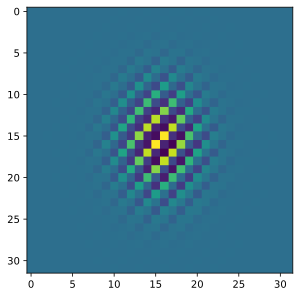

In [19]:
# read trixi output
with h5py.File('out/solution_000031.h5', 'r') as f:
    # average every 16 points to reduce the number of points
    temp = np.array([np.mean(x) for x in f['variables_1'][:].reshape(-1, 16)])
    plt.imshow(temp[:].reshape(SETUP['ny'], SETUP['nx']).transpose())
    plt.show()

In [20]:
trixi_result = temp[:].reshape(SETUP['ny'], SETUP['nx']).transpose()

# Calculate rmse between Trixi and PyMPDATA output
rmse = np.sqrt(np.mean((states_history[-1] - trixi_result) ** 2))
print(f"RMSE: {rmse:.4f}")

# Calculate min-max difference between Trixi and PyMPDATA output
min_max_diff = np.max(np.abs(states_history[-1] - trixi_result))
print(f"Min-max difference: {min_max_diff:.4f}")

RMSE: 7.9836
Min-max difference: 52.1232


In [21]:
with h5py.File('out/solution_000000.h5', 'r') as f:
    trixi_init = np.array([np.mean(x) for x in f['variables_1'][:].reshape(-1, 16)])
    trixi_init = trixi_init[:].reshape(SETUP['ny'], SETUP['nx']).transpose()

In [22]:
assert np.abs(np.sum(states_history[-1]) - np.sum(states_history[0])) < 1e-6
assert np.abs(np.sum(trixi_result) - np.sum(trixi_init)) < 1e-6

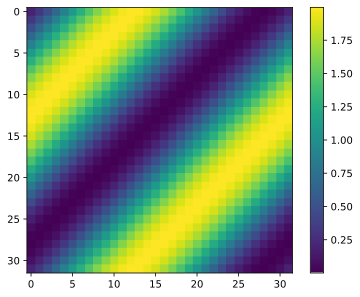

HTML(value="<a href='./tmp04a_jlnm.pdf' target='_blank'>./tmp04a_jlnm.pdf</a><br>")

In [23]:
solution_symbolic_final = sp.sympify("sin(pi*(x-cx*t + y-cy*t)) + 1", rational=True)
def final_conditions(x, y):
    return solution_symbolic_final.subs({"cx": Cx, "cy": Cy, "t":SETUP['tmax'], "x": x, "y": y}).evalf()

z_final = np.array(
    [
        # [
            final_conditions(x, y) for x in np.linspace(min_x, max_x, SETUP['nx'])
        # ]
        for y in np.linspace(min_y, max_y, SETUP['ny'])
    ],
    dtype=float
).reshape((SETUP['nx'], SETUP['ny']))

plt.imshow(z_final, cmap='viridis')
plt.colorbar()
show_plot()

In [24]:
# Calculate rmse between analytical solution, Trixi and PyMPDATA output
rmse = np.sqrt(np.mean((states_history[-1] - z_final) ** 2))
print(f"PyMPDATA - RMSE: {rmse:.4f}")

rmse = np.sqrt(np.mean((trixi_result - z_final) ** 2))
print(f"Trixi - RMSE: {rmse:.4f}")

PyMPDATA - RMSE: 0.6796
Trixi - RMSE: 7.9917


In [25]:
# Calculate min-max difference between analytical solution, Trixi and PyMPDATA output
min_max_diff = np.max(np.abs(states_history[-1] - z_final))
print(f"PyMPDATA - Min-max difference: {min_max_diff:.4f}")

min_max_diff = np.max(np.abs(trixi_result - z_final))
print(f"Trixi - Min-max difference: {min_max_diff:.4f}")

PyMPDATA - Min-max difference: 1.1064
Trixi - Min-max difference: 53.1039


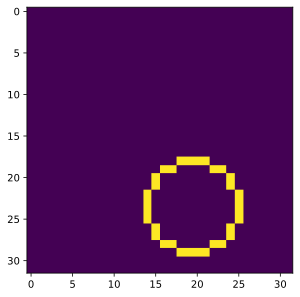

In [37]:
# Plot the edges of the shape with FWHM
fwhm_edges = get_fwhm_edges(states_history[-1])
plt.imshow(fwhm_edges)

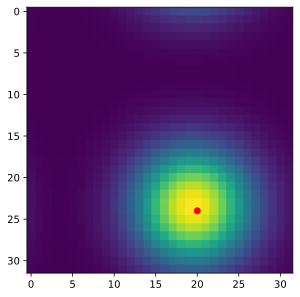

In [34]:
# Find a point with the highest value
max_value = np.max(states_history[-1])
max_value_idx = np.where(states_history[-1] == max_value)

# Plot the point with the highest value
plt.imshow(states_history[-1])
plt.plot(max_value_idx[1], max_value_idx[0], 'ro')

In [38]:
# Calculate the distance between the point with the highest value and each point on the edge of the shape
distances = np.zeros_like(fwhm_edges, dtype=float)
for i in range(fwhm_edges.shape[0]):
    for j in range(fwhm_edges.shape[1]):
        if fwhm_edges[i, j] == 1:
            distances[i, j] = np.sqrt((i - max_value_idx[0][0])**2 + (j - max_value_idx[1][0])**2)

In [46]:
# Display the highest and shortest distance and its coordinates
max_distance = np.max(distances)
max_distance_idx = np.where(distances == max_distance)
min_distance = np.min(np.where(distances > 0, distances, np.inf))
min_distance_idx = np.where(distances == min_distance)
print(f"Max distance: {max_distance} at {max_distance_idx[0][0]}, {max_distance_idx[1][0]}")
print(f"Min distance: {min_distance} at {min_distance_idx[0][0]}, {min_distance_idx[1][0]}")

Max distance: 6.4031242374328485 at 19, 16
Min distance: 4.47213595499958 at 26, 24


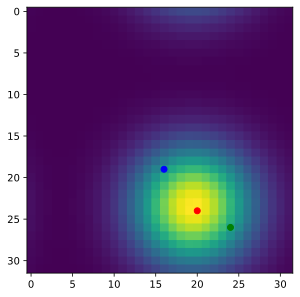

In [58]:
# Plot the points with the highest and shortest distance
plt.imshow(states_history[-1])
plt.plot(max_value_idx[1], max_value_idx[0], 'ro')
plt.plot(max_distance_idx[1][0], max_distance_idx[0][0], 'bo')
plt.plot(min_distance_idx[1][0], min_distance_idx[0][0], 'go')